# Importing the necessary libraries

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import joblib
from joblib import dump
from mlxtend.plotting import plot_learning_curves
from lime import lime_tabular
from lime.lime_text import LimeTextExplainer

# Importing Data

In [2]:
# open the csv file and read it
data = pd.read_csv('diabetes_data_upload.csv')

# Exploratory data analysis (EDA)

In [3]:
# display data
data

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [4]:
# Display the Complete Meta-Data of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [5]:
# Checking if there is any null in the dataset
data.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

### Modifying data

##### *Discretizing the Age data into three groups, based on the medical opinion for diabetes

In [6]:
modData = data.copy()
# discretizing the Age data into three groups, based on the medical opinion for diabetes
modData['Age'] = modData['Age'].mask(modData['Age'] < 40, 1)
modData['Age'] = modData['Age'].mask(modData['Age'] >= 65, 3)
modData['Age'] = modData['Age'].mask(modData['Age'] >= 40, 2)

In [7]:
# convert binary string data into 1 and 0 
modData = modData.mask(modData == 'Yes', 1)
modData = modData.mask(modData == 'No', 0)
modData = modData.mask(modData == 'Male', 1)
modData = modData.mask(modData == 'Female', 0)
modData = modData.mask(modData == 'Positive', 1)
modData = modData.mask(modData == 'Negative', 0)
modData.iloc[:,:] = modData.iloc[:,:].astype(int)

In [8]:
# display data after modifying it
modData

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,2,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,2,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,2,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,2,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,2,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,2,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


C:\Users\user\AppData\Local\Temp\ipykernel_1944\3531764799.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  [modData[modData[modData.columns[counter]] == 1][modData['class'] == 1].count()[0],
C:\Users\user\AppData\Local\Temp\ipykernel_1944\3531764799.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  modData[modData[modData.columns[counter]] == 1][modData['class'] == 0].count()[0],
C:\Users\user\AppData\Local\Temp\ipykernel_1944\3531764799.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  modData[modData[modData.columns[counter]] == 0][modData['class'] == 1].count()[0],
C:\Users\user\AppData\Local\Temp\ipykernel_1944\3531764799.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  modData[modData[modData.columns[counter]] == 0][modData['class'] == 0].count()[0]],
C:\Users\user\AppData\Local\Temp\ipykernel_1944\3531764799.py:23: UserWarning: Boolean Ser

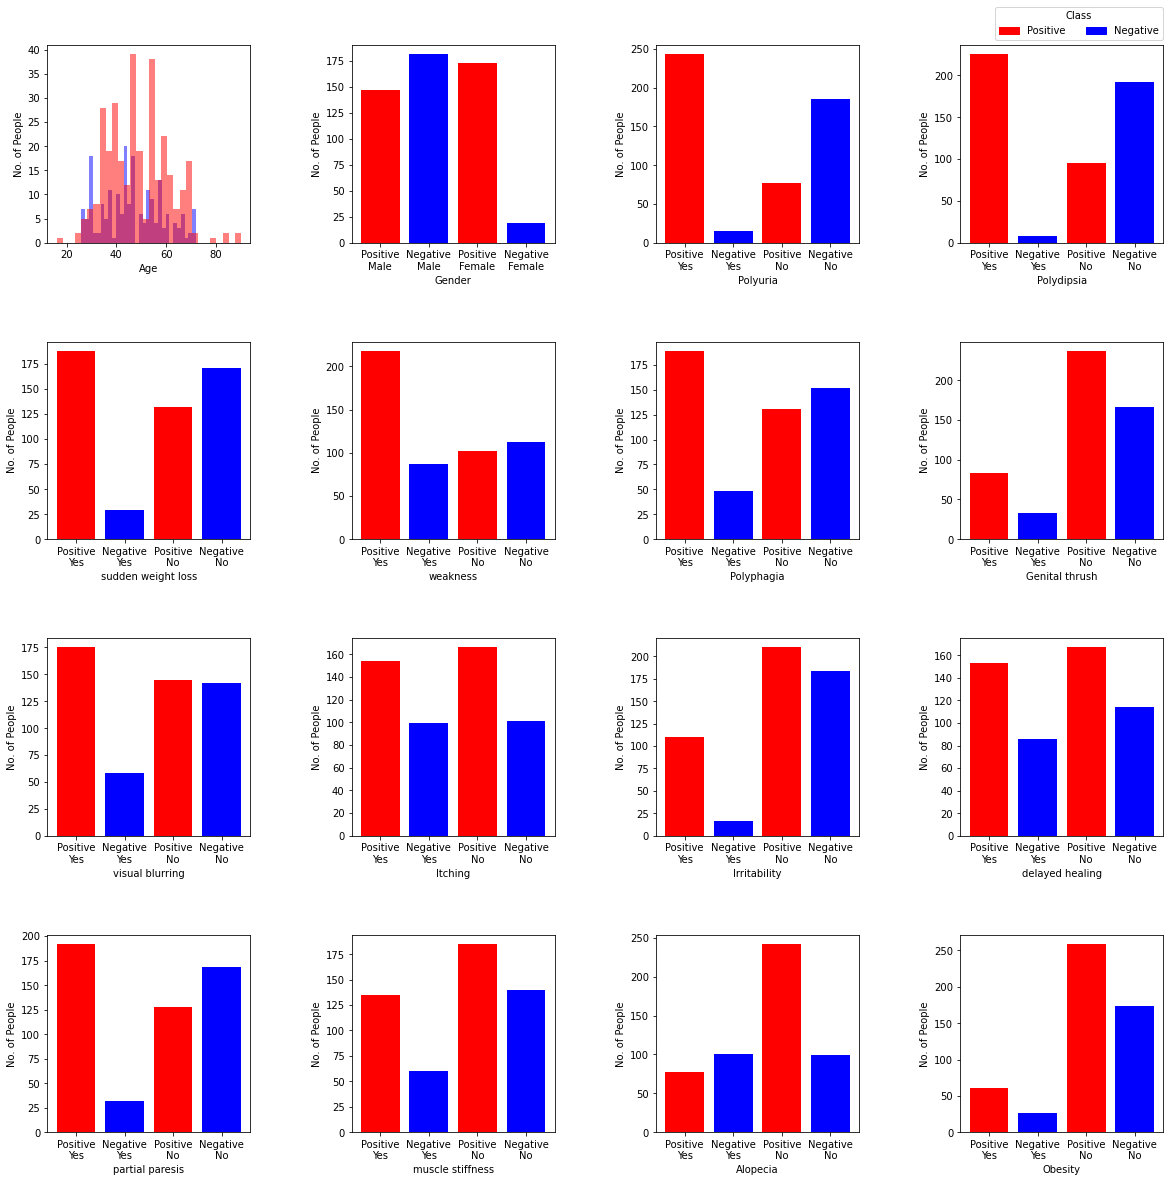

In [9]:
# Visiualizing each Feature
figure, axis = plt.subplots(4, 4, figsize=(20,20))

axis[0, 0].hist(data['Age'][data['class'] == 'Negative'], alpha=0.5, bins = 30, histtype ='bar', color = 'blue')
axis[0, 0].hist(data['Age'][data['class'] == 'Positive'], alpha=0.5, bins = 30, histtype ='bar', color = 'red')
axis[0, 0].set_xlabel("Age")
axis[0, 0].set_ylabel('No. of People')

legendElements = [Patch(facecolor='red', edgecolor='red', label='Positive'),
                 Patch(facecolor='blue', edgecolor='blue', label='Negative')]
yes = 'Yes'
no = 'No'
counter = 0
for i in range(4):
    for j in range(4):
        if i == j == 0:
            counter += 1
            continue
        if i == 0 and j == 1:
            yes = 'Male'
            no = 'Female'
        axis[i, j].bar(['Positive\n' + yes, 'Negative\n' + yes, 'Positive\n' + no, 'Negative\n' + no],
                       [modData[modData[modData.columns[counter]] == 1][modData['class'] == 1].count()[0],
                        modData[modData[modData.columns[counter]] == 1][modData['class'] == 0].count()[0],
                        modData[modData[modData.columns[counter]] == 0][modData['class'] == 1].count()[0],
                        modData[modData[modData.columns[counter]] == 0][modData['class'] == 0].count()[0]],
                       color = ['red', 'blue', 'red', 'blue'], width = 0.8)
        axis[i, j].set_xlabel(modData.columns[counter])
        axis[i, j].set_ylabel('No. of People')
        if i == 0 and j == 1:
            yes = 'Yes'
            no = 'No'
        counter += 1


plt.subplots_adjust(wspace=0.5, hspace=0.5)
figure.legend(handles = legendElements, title = 'Class', loc='upper right', bbox_to_anchor=(0.903, 0.91), ncol=2)
plt.show()

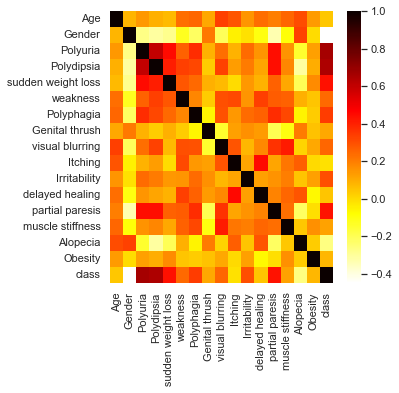

In [10]:
# plotting correlation heatmap
sns.set(rc = {'figure.figsize':(5,5)})
sns.heatmap(modData.corr(), cmap="hot_r", annot=False)

# displaying heatmap
plt.show()

# Machine Learning Models
##### *Decision tree and logistic regression models were built becuase they are good algorithms for small datasets
#### *In addition to RandomForest being good for small datasets, its good to avoid overfitting because its prediction is based on multiple decision trees.

### Building the decision tree model

In [11]:
# function responsible to create a decision tree based on the dataset you provide
def dtModel(dataset, X_train, X_test, Y_train, Y_test):

    if len(dataset.columns) == 11:
        name = 'pruned_dt'
    else:
        name = 'dt'
        
    # creating the classification model by building a decision tree
    dt = tree.DecisionTreeClassifier()
    # adjusting weights according to data values so that better accuracy can be achieved
    dt.fit(X_train, Y_train)    
    
    # testing model and printing the classification report (quality of predictions)
    Y_pred = dt.predict(X_test)
    print(metrics.classification_report(Y_test,Y_pred))
    
    # displaying the confusion matrix on a heatmap
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(7)
    
    plt.subplot(1, 2, 1)
    mat = confusion_matrix(Y_test, Y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    
    plt.subplot(1, 2, 2)
    plot_learning_curves(X_train, Y_train, X_test, Y_test, dt)
    plt.show()
    
    dump(dt, name + '.joblib')

### Decision tree pruning

In [12]:
# measuring k highest scores for each feature to lowering the overfitting
array = modData.values
X = array[:,0:len(modData.columns)-1]
Y = array[:,len(modData.columns)-1]

# Feature extraction
test = SelectKBest(score_func=chi2)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[1.895e-01 3.875e+01 1.162e+02 1.208e+02 5.775e+01 1.272e+01 3.320e+01
 4.914e+00 1.812e+01 4.783e-02 3.533e+01 6.202e-01 5.531e+01 4.875e+00
 2.440e+01 2.250e+00]


In [13]:
# removing featrues that doesn't help in building the tree
newData = modData.drop(columns=['Age', 'Itching', 'delayed healing', 'Genital thrush', 'muscle stiffness', 'Obesity'])

In [14]:
# Random Forest 
def randFor(dataset, X_train, X_test, Y_train, Y_test):

    grid_search = {'criterion': ['entropy', 'gini'],
                   'max_depth': [3, 5, 7],
                   'max_features': ['log2', 'auto', 'sqrt'],
                   'min_samples_leaf': [4, 6, 8],
                   'min_samples_split': [3, 5, 7, 9],
                   'n_estimators': [10]}

    # creating a RF classifier
    clf = RandomForestClassifier()
    model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                                   cv = 10, verbose= 5, n_jobs = -1)
    
    model.fit(X_train, Y_train)

    Y_pred = model.best_estimator_.predict(X_test)
    print(metrics.classification_report(Y_test,Y_pred))
    
    # displaying the confusion matrix on a heatmap
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(7)
    
    plt.subplot(1, 2, 1)
    mat = confusion_matrix(Y_test, Y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    
    plt.subplot(1, 2, 2)
    plot_learning_curves(X_train, Y_train, X_test, Y_test, model.best_estimator_)
    plt.show()
    
    dump(model.best_estimator_, 'randFor.joblib')

### Building a logistic regression model

In [15]:
# function responsible to create a logistic regression model based on the dataset you provide
def logReg(dataset, X_train, X_test, Y_train, Y_test):
    
    # creating the classification model
    classifier = LogisticRegression(random_state = 0)
    # adjusting weights according to data values so that better accuracy can be achieved
    classifier.fit(X_train, Y_train)
    
    # testing model and printing the classification report (quality of predictions)
    Y_pred = classifier.predict(X_test)
    print(metrics.classification_report(Y_test,Y_pred))

    # displaying the confusion matrix on a heatmap
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(7)
    
    plt.subplot(1, 2, 1)
    mat = confusion_matrix(Y_test, Y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    
    plt.subplot(1, 2, 2)
    plot_learning_curves(X_train, Y_train, X_test, Y_test, classifier)
    plt.show()
    
    dump(classifier, 'logReg.joblib')

### Building a neural network model

In [16]:
# function responsible to create a neural network model based on the dataset you provide
def neuNet(dataset, X_train, X_test, Y_train, Y_test):
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=len(dataset.columns)-1))
    #Second  Hidden Layer
    #classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    #Fitting the data to the training dataset
    classifier.fit(X_train, Y_train, batch_size=10, epochs=150)
    
    eval_model = classifier.evaluate(X_train, Y_train)
    
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.5)
    
    # displaying the confusion matrix on a heatmap
    mat = confusion_matrix(Y_test, y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    
    
    classifier.save('neuNet.h5')

# Running the models

#### Decision tree, logistic regrission, and neural networks data

In [17]:
# dividing dataset into X (features, input) and Y (class, output) 
X = modData.iloc[:,:len(modData.columns)-1]
Y = modData.iloc[:,len(modData.columns)-1]
# splitting dataset intp X and Y train, and X and Y test subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30)

#### Pruned decision tree data

In [18]:
# dividing dataset into X (features, input) and Y (class, output) 
X = newData.iloc[:,:len(newData.columns)-1]
Y = newData.iloc[:,len(newData.columns)-1]
# splitting dataset intp X and Y train, and X and Y test subsets
p_X_train, p_X_test, p_Y_train, p_Y_test = train_test_split(X, Y, test_size = 0.30)

#### 1. Decision tree

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        52
           1       0.98      0.93      0.96       104

    accuracy                           0.94       156
   macro avg       0.93      0.95      0.94       156
weighted avg       0.95      0.94      0.94       156



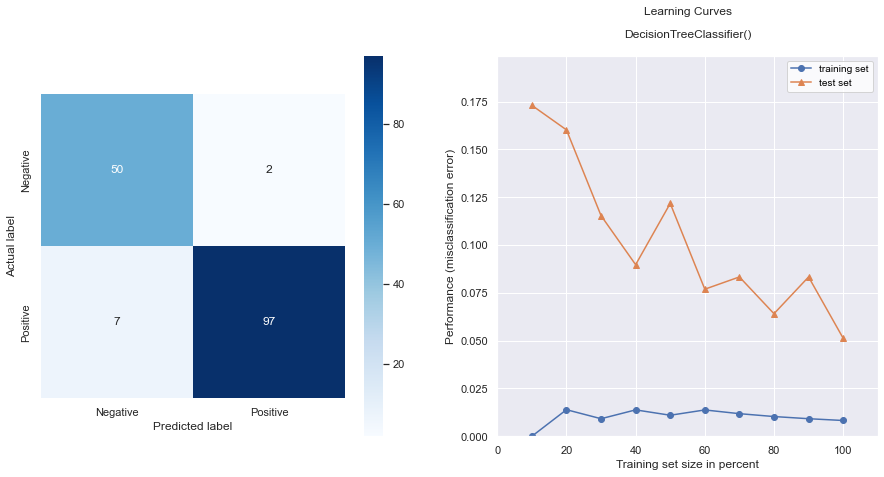

In [19]:
dtModel(modData, X_train, X_test, Y_train, Y_test)

#### 2. Pruned Decision tree

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        57
           1       0.96      0.87      0.91        99

    accuracy                           0.89       156
   macro avg       0.88      0.90      0.89       156
weighted avg       0.90      0.89      0.89       156



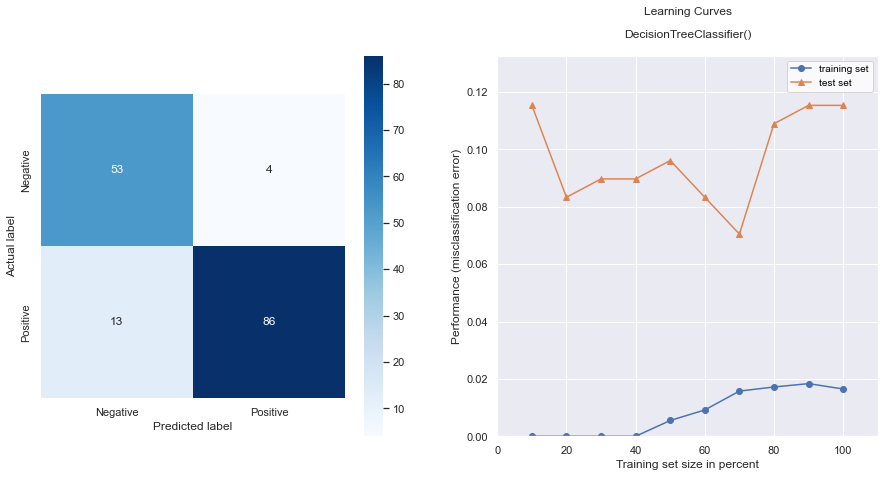

In [20]:
dtModel(newData, p_X_train, p_X_test, p_Y_train, p_Y_test)

#### 3. RandomForest

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

              precision    recall  f1-score   support

           0       0.89      0.96      0.93        52
           1       0.98      0.94      0.96       104

    accuracy                           0.95       156
   macro avg       0.94      0.95      0.94       156
weighted avg       0.95      0.95      0.95       156



C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

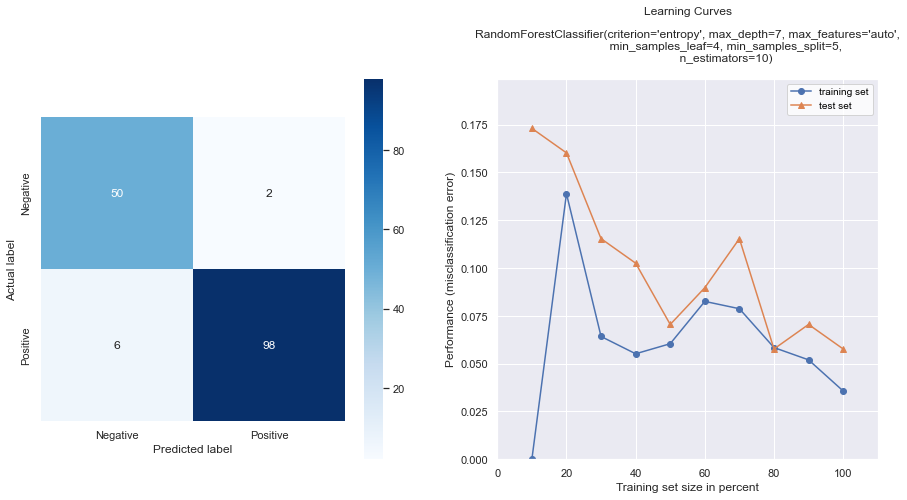

In [21]:
randFor(modData, X_train, X_test, Y_train, Y_test)

#### 4. Logistic regression

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        52
           1       0.96      0.97      0.97       104

    accuracy                           0.96       156
   macro avg       0.95      0.95      0.95       156
weighted avg       0.95      0.96      0.96       156



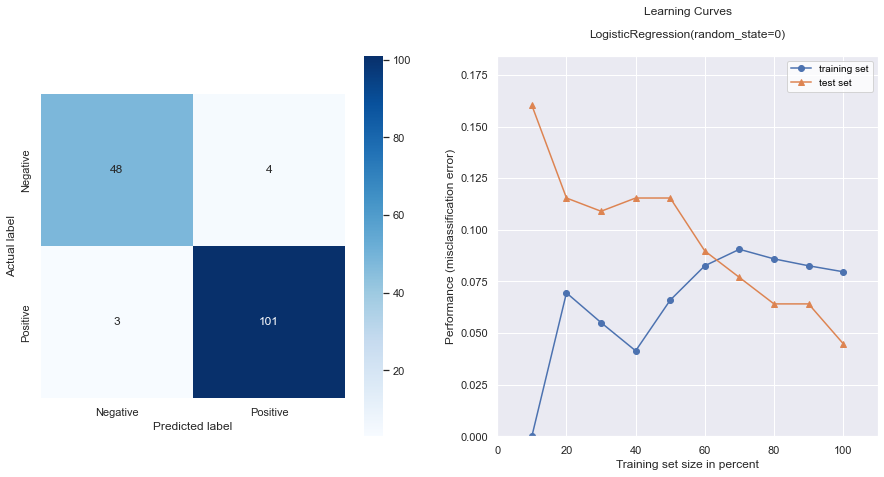

In [22]:
logReg(modData, X_train, X_test, Y_train, Y_test)

#### 5. Neural Networks

Epoch 1/150
37/37 [==============================] - 1s 2ms/step - loss: 0.6878 - accuracy: 0.5879
Epoch 2/150
37/37 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.5934
Epoch 3/150
37/37 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.5934
Epoch 4/150
37/37 [==============================] - 0s 2ms/step - loss: 0.6320 - accuracy: 0.5934
Epoch 5/150
37/37 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.5934
Epoch 6/150
37/37 [==============================] - 0s 2ms/step - loss: 0.5840 - accuracy: 0.5934
Epoch 7/150
37/37 [==============================] - 0s 2ms/step - loss: 0.5636 - accuracy: 0.5934
Epoch 8/150
37/37 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.5934
Epoch 9/150
37/37 [==============================] - 0s 2ms/step - loss: 0.5274 - accuracy: 0.5934
Epoch 10/150
37/37 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.6648
Epoch 11/

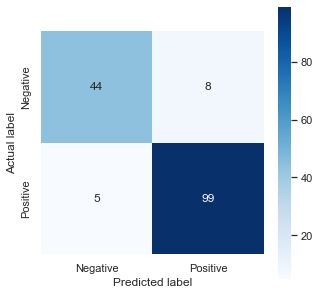

In [23]:
neuNet(modData, X_train, X_test, Y_train, Y_test)

# Instance prediction with Explaination

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


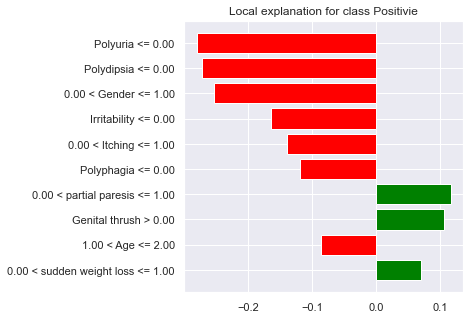

In [24]:
# The instance we are making prediction for feature values
data_instance = np.array([2,1,0,0,1,1,0,1,1,1,0,1,1,1,1,1])

# Class name
class_names = ['Negative', 'Positivie']

# Loading the model
model = joblib.load('logReg.joblib')

# Making prediction and explaining it
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=class_names,
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=data_instance, 
    predict_fn=model.predict_proba
)

exp.as_pyplot_figure()
exp.show_in_notebook()